# Aligning two visium datasets

In this notebook, we align two spot resolution spatial transcriptomics datasets of serial sections of breast cancer.

courtesy of:
Ståhl, Patrik & Salmén, Fredrik & Vickovic, Sanja & Lundmark, Anna & Fernandez Navarro, Jose & Magnusson, Jens & Giacomello, Stefania & Asp, Michaela & Westholm, Jakub & Huss, Mikael & Mollbrink, Annelie & Linnarsson, Sten & Codeluppi, Simone & Borg, Åke & Pontén, Fredrik & Costea, Paul & Sahlén, Pelin Akan & Mulder, Jan & Bergmann, Olaf & Frisén, Jonas. (2016). Visualization and analysis of gene expression in tissue sections by spatial transcriptomics. Science. 353. 78-82. 10.1126/science.aaf2403.

Note: Original data is (.tsv), but converted to (.csv) by https://github.com/raphael-group/paste/tree/main


We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
# OPTION A: import STalign after pip or pipenv install
from STalign import STalign

In [2]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `merfish_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [3]:
# Single cell data 1
# read in data
fname = '../visium_data/slice1_coor.csv'
df1 = pd.read_csv(fname)
print(df1.head())

   1.306400000000000006e+01  6.086000000000000298e+00
0                    12.116                     7.015
1                    13.945                     6.999
2                    12.987                     7.011
3                    15.011                     7.984
4                    12.050                     8.018


For alignment with `STalign`, we only need the cell centroid information so we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

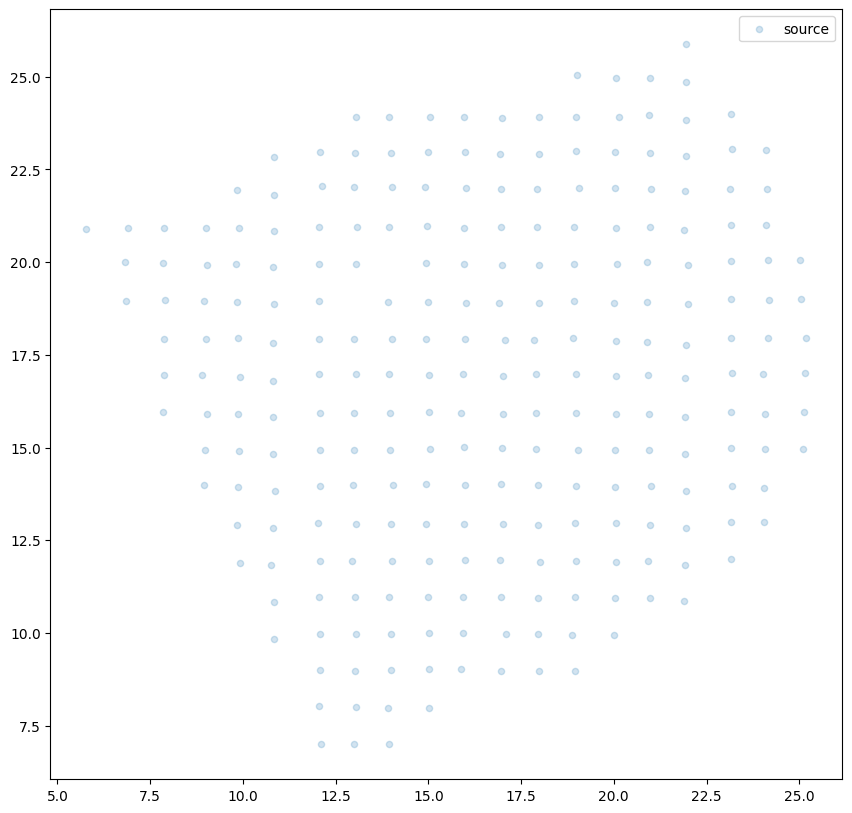

In [4]:
# get cell centroid coordinates
xI = np.array(df1['1.306400000000000006e+01'])
yI = np.array(df1['6.086000000000000298e+00'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=20,alpha=0.2, label='source')
ax.legend(markerscale = 1)
ax.set_aspect('equal')

Now, we can repeat this to get cell information from the second dataset.

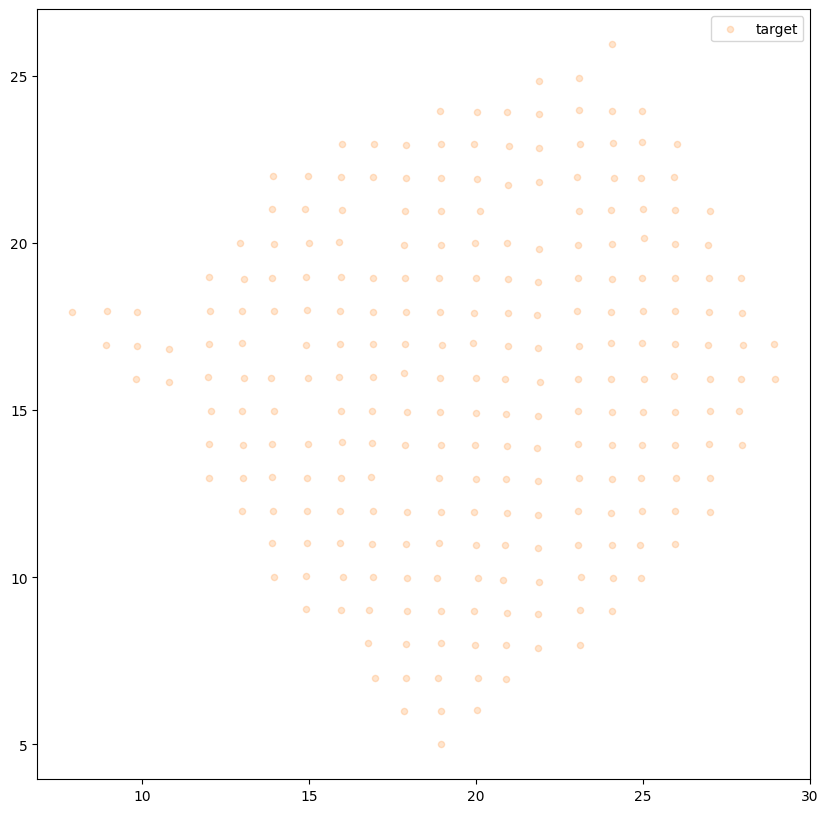

In [5]:
# Single cell data 1
# read in data
fname = '../visium_data/slice2_coor.csv'
df2 = pd.read_csv(fname)

# get cell centroids
xJ = np.array(df2[df2.columns[0]])
yJ = np.array(df2[df2.columns[1]])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=20,alpha=0.2,c='#ff7f0e', label='target')
ax.legend(markerscale = 1)
ax.set_aspect('equal')

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

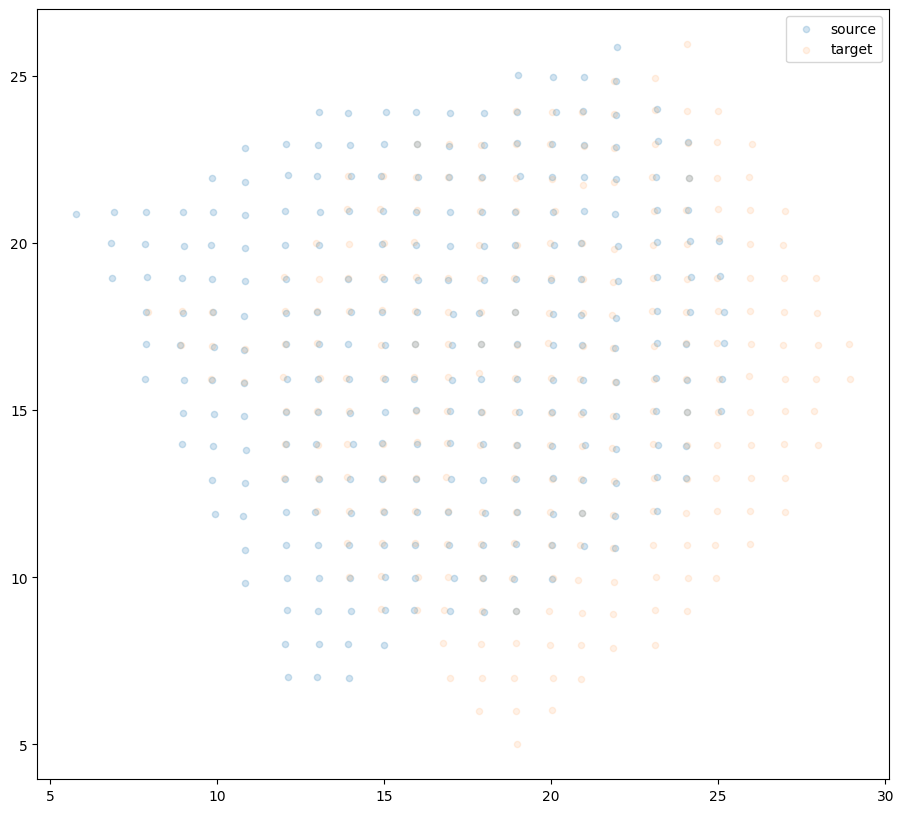

In [6]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=20,alpha=0.2, label='source')
ax.scatter(xJ,yJ,s=20,alpha=0.1, label= 'target')
ax.legend(markerscale = 1)
ax.set_aspect('equal')

`STalign` relies on an interative gradient descent to align these two images. This performs quicker and better if the source and target are initially at a similar angle.

Evaluate the similarity of the rotation angle by viewing a side by side comparison. Change the value of `theta_deg`, until the rotation angle is similar. Note: the rotation here is defined in degrees and is in the clockwise direction.

The angle chosen will be used to construct a 2x2 rotation matrix `L` and a 2 element translation vector `T`.

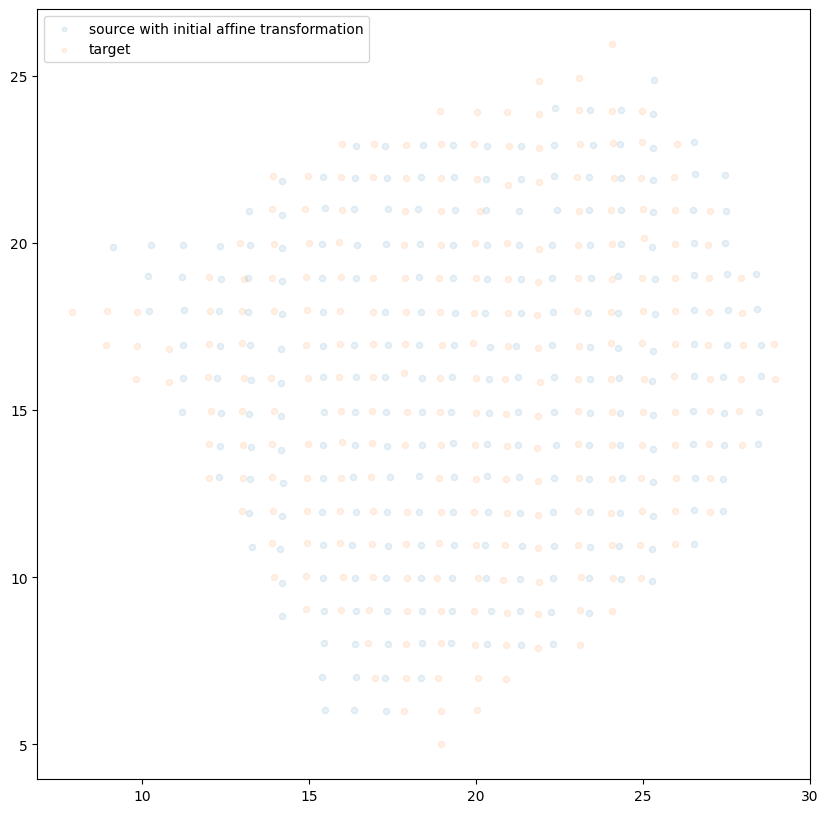

In [7]:
theta_deg = 0
theta0 = (np.pi/180)*-theta_deg

#rotation matrix 
#rotates about the origin
L = np.array([[np.cos(theta0),-np.sin(theta0)],
              [np.sin(theta0),np.cos(theta0)]])

source_L = np.matmul(L , np.array([xI, yI]))
xI_L = source_L[0]
yI_L = source_L[1]

#translation matrix
#effectively makes the rotation about the centroid of I (i.e the means of xI and yI]) 
#and also moves the centroid of I to the centroid of J
T = np.array([ np.mean(xI)- np.cos(theta0)*np.mean(xI) +np.sin(theta0)*np.mean(yI) - (np.mean(xI)-np.mean(xJ)),
              np.mean(yI)- np.sin(theta0)*np.mean(xI) -np.cos(theta0)*np.mean(yI) - (np.mean(yI)-np.mean(yJ))])

xI_L_T = xI_L + T[0]
yI_L_T = yI_L + T[1]


fig,ax = plt.subplots()
ax.scatter(xI_L_T,yI_L_T,s=20,alpha=0.1, label='source with initial affine transformation')
ax.scatter(xJ,yJ,s=20,alpha=0.1, label = 'target')

lgnd = plt.legend(scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

ax.set_aspect('equal')

Now, we will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 253
252 of 253


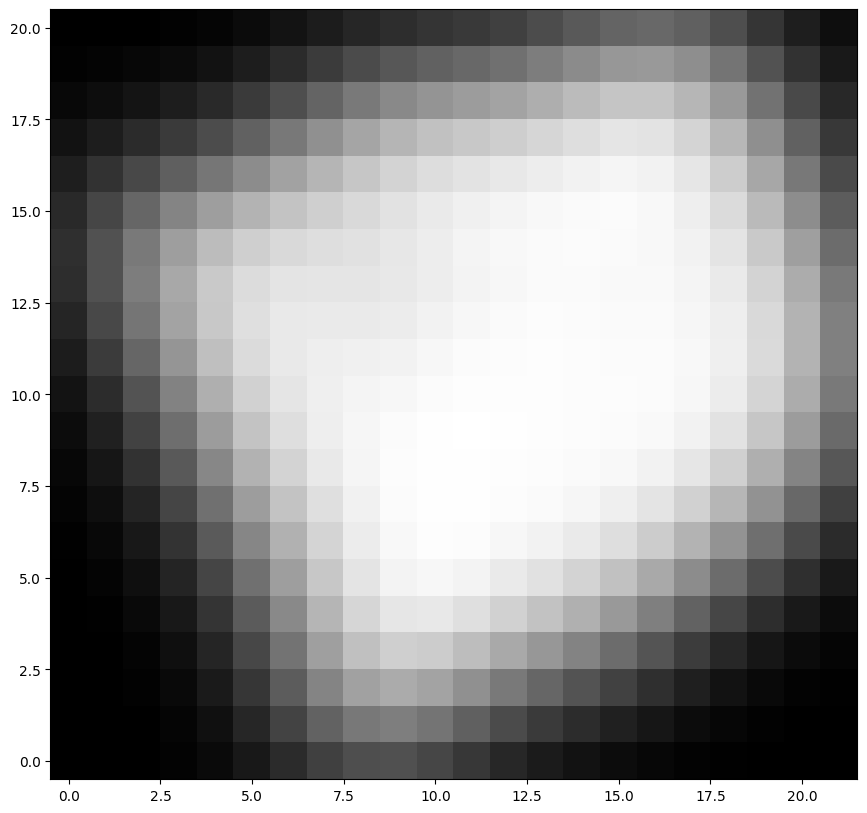

In [8]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
#XI,YI,I,fig = STalign.rasterize(xI_L_T,yI_L_T,dx=15,blur=1.5)
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=1)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Repeat rasterization for target dataset.

0 of 250
249 of 250


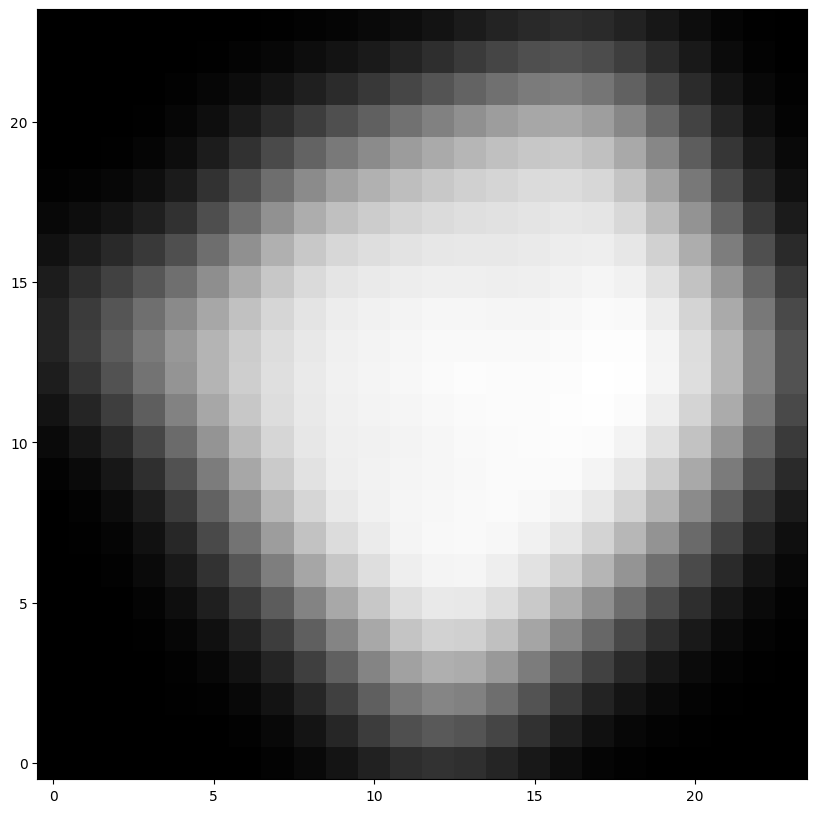

In [9]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=1)
ax = fig.axes[0]
ax.invert_yaxis()

We can also plot the rasterized images next to each other.

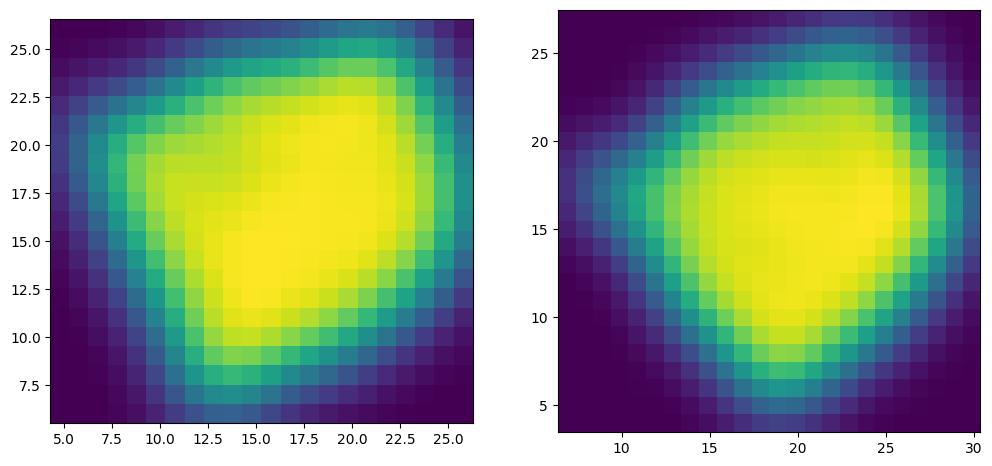

In [10]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(I.transpose(1,2,0).squeeze(), extent=extentI) 
ax[1].imshow(J.transpose(1,2,0).squeeze(), extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1043: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/Users/kalenclifton/.local/share/virtualenvs/STalign-wXTCUYXW/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3

CPU times: user 24.9 s, sys: 277 ms, total: 25.1 s
Wall time: 24.1 s


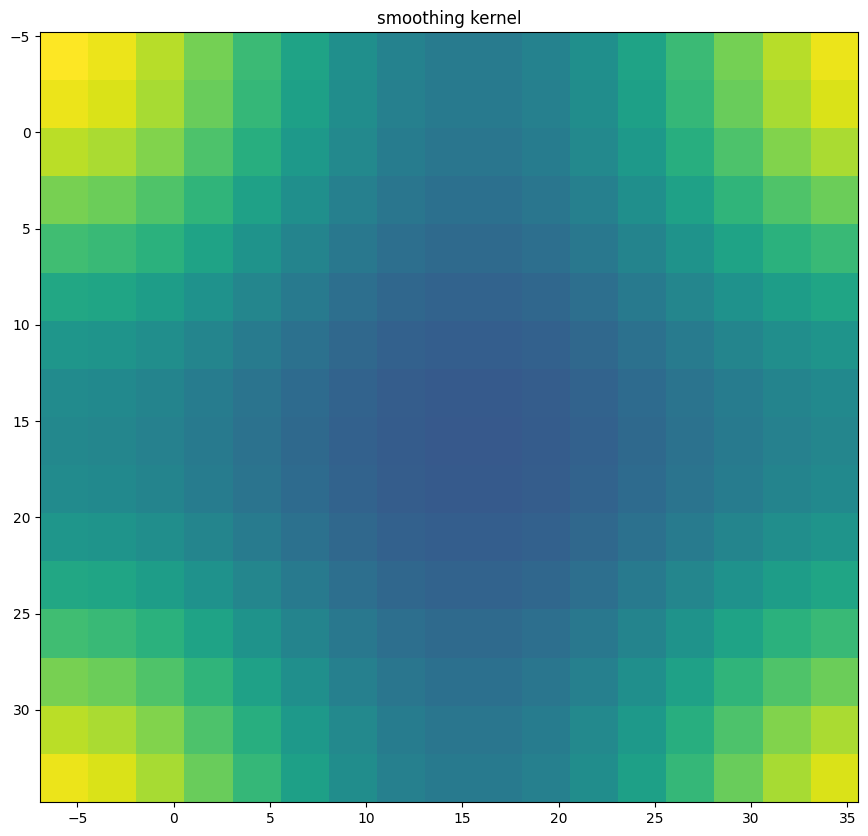

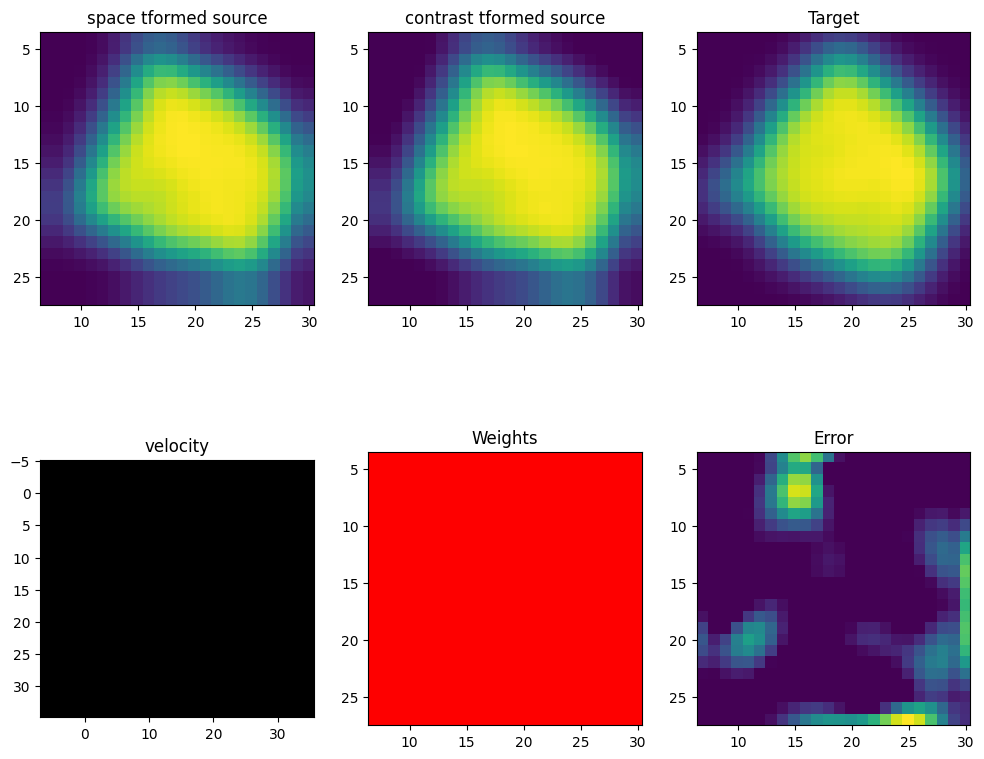

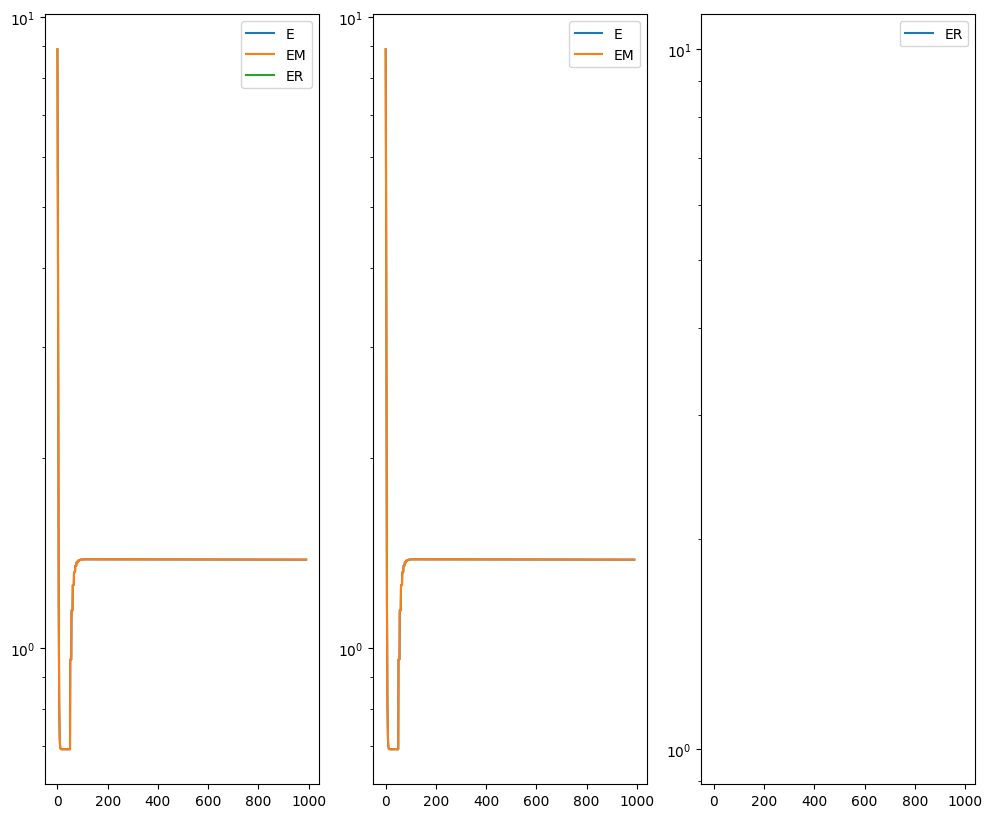

In [11]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {  'a': 5,
            'niter': 1000,
            'diffeo_start': 1001,
            'device':device,
            #'epV': 50
          }

#Ifoo = np.vstack((I, I, I)) # make RGB instead of greyscale
#Jfoo = np.vstack((J, J, J)) # make RGB instead of greyscale
#out = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)
out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [12]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1660: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1661: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if v is not None: v = torch.tensor(v)
/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


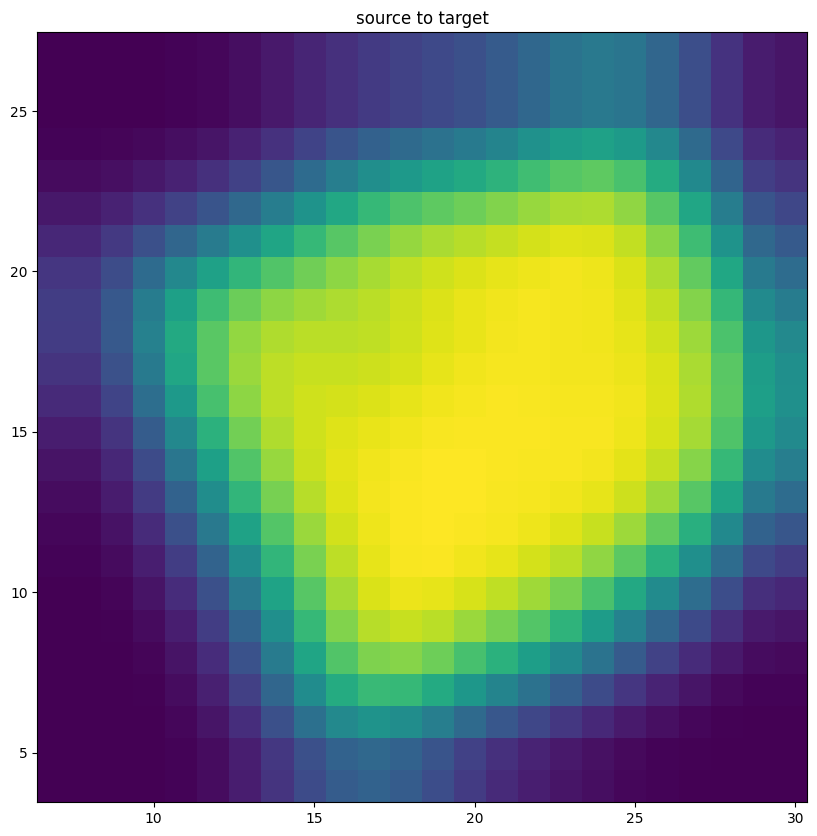

In [13]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

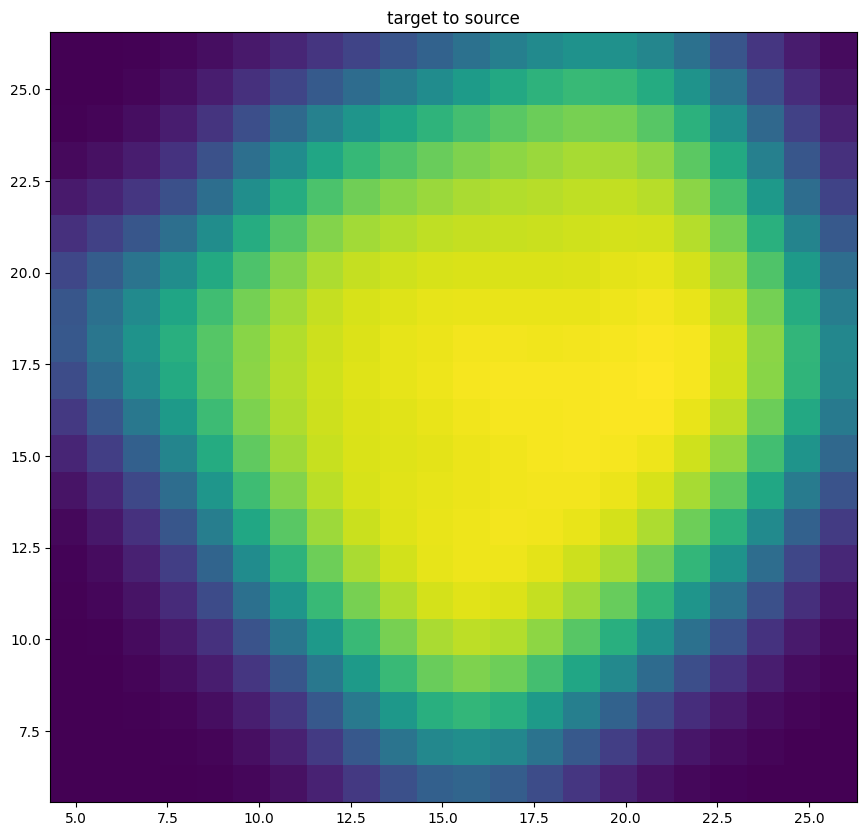

In [14]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

Finally, we can apply our STalign transform to the original sets of single cell centroid positions (with initial affine transformation) to achieve their new aligned positions.

In [15]:
# apply transform to original points with initial affine transformation
#tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI_L_T, xI_L_T], 1))
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

And we can visualize the results.

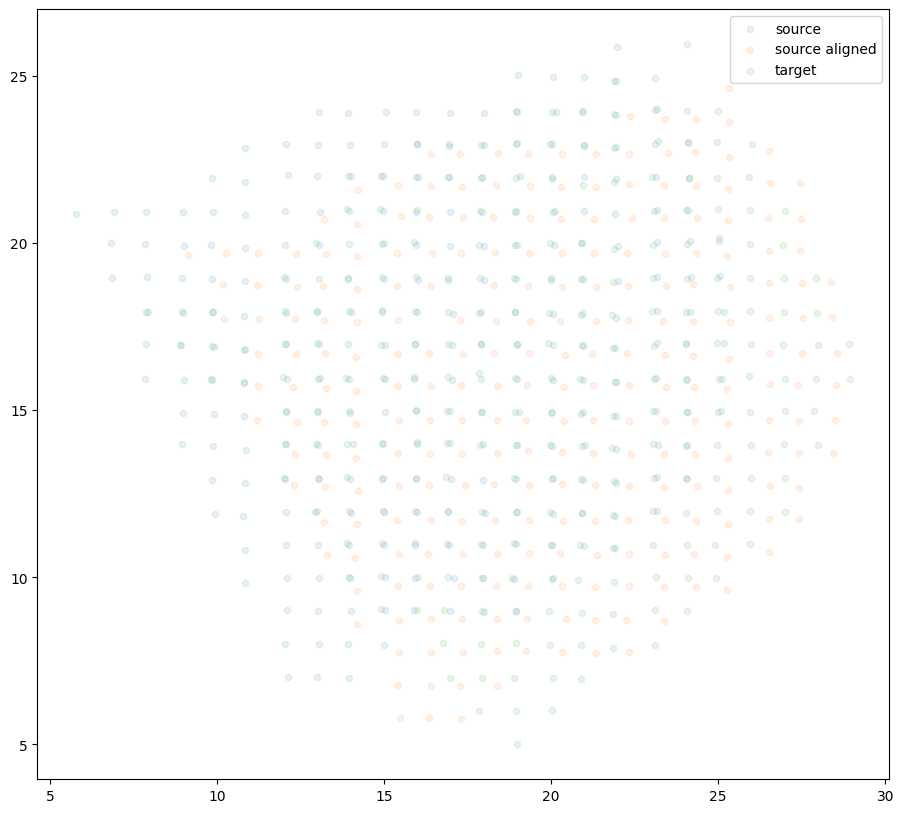

In [16]:
# plot results
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=20,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=20,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=20,alpha=0.1, label='target')

lgnd = plt.legend(scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([20.0])

ax.set_aspect('equal')

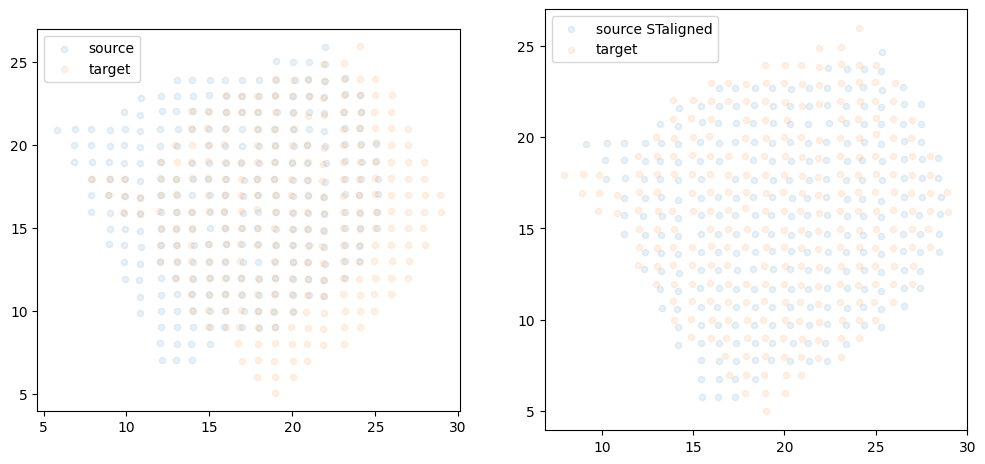

In [17]:
fig,ax = plt.subplots(1,2)
#ax[0].scatter(xI_L_T,yI_L_T,s=20,alpha=0.1, label='source with initial affine transformation')
ax[0].scatter(xI,yI,s=20,alpha=0.1, label='source')
ax[0].scatter(xJ,yJ,s=20,alpha=0.1, label='target')
ax[1].scatter(xI_LDDMM,yI_LDDMM,s=20,alpha=0.1, label = 'source STaligned') 
ax[1].scatter(xJ,yJ,s=20,alpha=0.1, label='target')

lgnd = ax[0].legend(scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([20.0])

lgnd = ax[1].legend(scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([20.0])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

And save the new aligned positions by appending to our original data

In [18]:
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df1, df3], axis=1)
results.head()

,1.306400000000000006e+01,6.086000000000000298e+00,aligned_x,aligned_y
0,12.116,7.015,15.474331,5.778815
1,13.945,6.999,17.303186,5.762786
2,12.987,7.011,16.345261,5.774801
3,15.011,7.984,18.368953,6.747827
4,12.050,8.018,15.408186,6.781876


We will finally create a compressed `.csv.gz` file

In [19]:
results.to_csv('../visium_data/slice1_coor_STalign_to_slice2_coor_affine_only.csv.gz',
               compression='gzip')